# Get a Biomass function using a GSM

## Kugler2023
**Model Publication:**  
Kugler, A., Stensjö, K. Optimal energy and redox metabolism in the cyanobacterium Synechocystis sp. PCC 6803. npj Syst Biol Appl 9, 47 (2023). https://doi.org/10.1038/s41540-023-00307-3

**Available at:**  
https://github.com/amitkugler/CBA

## Knoop2015
**Model Publication:**  
Knoop H and Steuer R (2015) A computational analysis of stoichiometric constraints and trade-offs in cyanobacterial biofuel production. Front. Bioeng. Biotechnol. 3:47. doi: 10.3389/fbioe.2015.00047

**Available at:**  
https://www.frontiersin.org/articles/file/downloadfile/136766_supplementary-materials_datasheets_1_zip/octet-stream/Data%20Sheet%201.ZIP/1/136766?isPublishedV2=False

In [21]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import warnings

from cobra.io import load_json_model, read_sbml_model
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba

from cobra import Model, Reaction, Metabolite
from cobra.manipulation.validate import check_mass_balance

from modelbase.ode import Simulator
from modelbase.ode import ratefunctions as rf

sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom

In [9]:
select_model = "Kugler2023"
# select_model = "Knoop2015"
# select_model = "Knoop2013"

In [10]:
def add_import(model, metabolite_name, reaction_stoichiometry, bounds=(-1000,1000)):
    # Define the reaction
    reac = Reaction(f'{metabolite_name}_import')
    reac.name = f'{metabolite_name} import'
    reac.bounds = bounds

    # Add the correct stoichiometry and add to the model
    reac.add_metabolites({model.metabolites.get_by_id(k): v for k,v in reaction_stoichiometry.items()})
    model.add_reactions([reac])
    
    return model

In [11]:
def get_stoichiometric_fluxes(model, solution, compound):
    # Get the reactions where the compound is involved and their stoichiometry
    react = solution.fluxes[[x.id for x in model.metabolites.get_by_id(compound).reactions]]
    stoich = pd.Series({x:model.reactions.get_by_id(x).metabolites[model.metabolites.get_by_id(compound)] for x in react.index})
    
    # Return the scaled flux according to the stoichiometry
    return react * stoich

In [12]:
# Load the model
if select_model == "Kugler2023":
    model = load_json_model('../GSM_models/Kugler2023/GSM/JSON/iJN678_AK.json')

    # Set phototrophic growth and modify the model as described in the Analysis by Kugler
    #set model objective to autotrophic growth
    model.objective = 'BIOMASS_Ec_SynAuto'
    #set photoautotropic growth by constraining glucose exchange reatcion
    model.reactions.EX_glc__D_e.bounds = (0, 1000)
    #set photoautotropic growth by constraining HCO3 exchange reatcion.
    model.reactions.EX_co2_e.bounds = (0, 1000)
    model.reactions.EX_hco3_e.bounds = (-3.7, 1000)
    #set photon flux to lab scale conditions.
    model.reactions.EX_photon_e.bounds = (-45, -45)
    #blocking transhydrogenase PntAB
    model.reactions.NADTRHD.bounds = (0, 0)

    # Make the model loopless (makes model infeasible)
    # add_loopless(model)

elif select_model == "Knoop2015":
    model = read_sbml_model("../GSM_models/Knoop2015/Knoop2015_Supplement_revised/Metabolic_Network_supplementary_File1.xml")

    # Constraints used for the FBA simulation
    # Photon input
    model.reactions.PR0001.bounds = (0,15.57)

elif select_model == "Knoop2013":
    model = read_sbml_model("../GSM_models/Knoop2013/pcbi.1003081.s002.xml")

In [13]:
with model:
    sol_loopless = loopless_solution(model)

In [14]:
solutions = {}
#############
# Get the default flux
solutions["default"] = model.optimize("maximize")
solutions["default_pfba"] = pfba(model)

In [16]:
model.summary(solutions["default"])

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.0003718,0,0.00%
cobalt2_e,EX_cobalt2_e,0.000268,0,0.00%
cu2_e,EX_cu2_e,0.0002479,0,0.00%
fe2_e,EX_fe2_e,0.0006168,0,0.00%
fe3_e,EX_fe3_e,0.0005616,0,0.00%
h_e,EX_h_e,4.071,0,0.00%
hco3_e,EX_hco3_e,3.451,1,99.99%
k_e,EX_k_e,0.01394,0,0.00%
mg2_e,EX_mg2_e,0.00237,0,0.00%
mn2_e,EX_mn2_e,0.0002496,0,0.00%


In [19]:

with model:
    ##############
    # With imports
    # Disable light reactions
    model.reactions.EX_photon_e.bounds = (0, 0)

    # Disable NDH-1 as we want to measure ATP import
    # model.reactions.get_by_id("NDH1_1u").bounds = (0, 0)
    # model.reactions.get_by_id('NDH1_2u').bounds = (0, 0)
    # model.reactions.get_by_id('NDH1_3u').bounds = (0, 0)
    # model.reactions.get_by_id('NDH1_4pp').bounds = (0, 0)
    

    # # Disable Terminal oxidases
    model.reactions.get_by_id('CYO1b_syn').bounds = (0, 0) # COX
    model.reactions.get_by_id("CYTBDu").bounds = (0, 0) # Cyd
    model.reactions.get_by_id("CYTBDpp_1").bounds = (0, 0) # Cyd
    model.reactions.get_by_id('Flv2_4').bounds = (0, 0) # Flv2/4
    model.reactions.get_by_id('ARTO').bounds = (0, 0) # ARTO

    # # Disable H2 production
    # model.reactions.get_by_id("H2ASE_syn").bounds = (0, 0)

    # # Disable Cyt b6f
    # model.reactions.get_by_id('CBFC2').bounds = (0, 0)

    # # Disable the Mehler reaction
    model.reactions.get_by_id("MEHLER").bounds = (0, 0)

    # # model.reactions.get_by_id("ATPS4rpp_1").bounds = (0,0)
    # model.reactions.get_by_id("ATPSu").bounds = (0,0)

    # Instead, add Exchange reactions for ATP, NADPH and 3PGA
    pseudo_reactions = {
        "3PGA":  ({"3pg_c":1}, (-1, 1)),
        "ATP":   ({"atp_c":1, "adp_c":-1}, (0, 1000)),
        "NADPH": ({"nadph_c":1, "h_c":1, "nadp_c":-1}, (0, 1000)),
        "H+": ({"h_c":1}, (-1000, 1000)),
    }
    for name, (stoich, bounds) in pseudo_reactions.items():
        model = add_import(model, name, stoich, bounds)

    # Set a new objective function
    model.objective = {
        model.reactions.get_by_id('BIOMASS_Ec_SynAuto'):0.9,
        model.reactions.get_by_id('ATP_import'):0.1,
    
    }

    # Disable other Carbon import reactions
    # HCO3 import
    # model.reactions.EX_hco3_e.lower_bound = 0

    solutions["imports"] = model.optimize("maximize")
    solutions["imports_pfba"] = pfba(model)

    print(model.summary(solutions["imports"]))

# Print a summary of the models
for nam, sol in solutions.items():
    print(f"""
model: {nam}
biomass: {sol.fluxes.get("BIOMASS_Ec_SynAuto")}
ATP: {sol.fluxes.get("ATP_import")}
NADPH: {sol.fluxes.get("NADPH_import")}
3PGA: {sol.fluxes.get("3PGA_import")}
""")

Objective
0.9 BIOMASS_Ec_SynAuto + 0.1 ATP_import = 0.11619772353098551

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
     ca2_e     EX_ca2_e 7.542E-05         0   0.00%
 cobalt2_e EX_cobalt2_e 5.436E-05         0   0.00%
     cu2_e     EX_cu2_e 5.028E-05         0   0.00%
     fe2_e     EX_fe2_e 0.0001251         0   0.00%
     fe3_e     EX_fe3_e 0.0001139         0   0.00%
       h_e       EX_h_e     51.67         0   0.00%
    hco3_e    EX_hco3_e       3.7         1 100.00%
       k_e       EX_k_e  0.002828         0   0.00%
     mg2_e     EX_mg2_e 0.0004808         0   0.00%
     mn2_e     EX_mn2_e 5.063E-05         0   0.00%
    mobd_e    EX_mobd_e 5.064E-05         0   0.00%
     na1_e     EX_na1_e  6.33E-05         0   0.00%
     no3_e     EX_no3_e    0.1507         0   0.00%
      o2_e      EX_o2_e  0.009053         0   0.00%
     so4_e     EX_so4_e  0.003171         0   0.00%
     zn2_e     EX_zn2_e 5.028E-05         0   0.00%
  rdmbzi_c  SK_rdmbzi_c 3.728

## Add biomass reaction to model

In [3]:
# Get the default model
_m = get_model(get_y0=False, verbose=False, check_consistency=False)

stoich_3PGA = pd.Series({
    "CO2": -3,
    "ATP": -8,
    "NADPH": -5,
    "3PGA": 1,
})

# Biomass stoichiometry as given in Knoop2015
# This reaction has to complete once for a full division
biomass_Knoop2015 = pd.Series({ # [mmol gDW(Biomass)^-1]
    "NADPH": -90, 
    "ATP": -191,
    "CO2": -41.5,
    
    "3PGA": 0, # Added for compliance with the model
})

# Transform to usage of 3PGA
biomass_Knoop2015 = biomass_Knoop2015 - (stoich_3PGA / stoich_3PGA["CO2"] * biomass_Knoop2015["CO2"])
biomass_Knoop2015 = biomass_Knoop2015.drop("CO2")
biomass_Knoop2015["Ho"] = biomass_Knoop2015["NADPH"] / _m.get_parameter("bHo")

# Calculate the conversion from gDW to mol(Chl)
mChl_DW = 10 # [mg gDW^-1] (Zavrel2019)
MChl = 893.509 # [g mol^-1]

nChl_DW = ( # [mol gDW^-1]
    mChl_DW 
    * 1e-3 # [g mg^-1]
    / MChl # [g mol^-1]
)

# Scale the biomass stoichiometry to mol Chl
biomass_Knoop2015 = biomass_Knoop2015 / nChl_DW # [mmol mol(Chl)^-1]


# Get the growth rate of the 633nm (red)-light grown cells
growth_rate= pd.read_csv("../Code/data/Strainparameters_Zavrel2021.csv", header=0,skiprows=1, index_col=0).loc["Specific growth rate","633"] # [h^-1]
growth_rate = growth_rate / 3600 # [s^-1]
# Get the default model
m, y0 = get_model(verbose=False, check_consistency=False)

# Set the initial 3PGA concentration to zero
y0["3PGA"] = 0

# Add a biomass reaction as Mass action
biomass_stoich = biomass_Knoop2015.to_dict()

# Add parameter(s) and reaction to model
m.add_parameter("k_biomass", growth_rate * 10)
m.add_reaction_from_args(
    "vBiomass",
    function = rf.mass_action_variable,
    stoichiometry = biomass_stoich,
    args = ["k_biomass"] + list(biomass_stoich.keys()),
)

Text(0.5, 0, 'Light intensity [µmol m$^{-2}$ s$^{-1}$]')

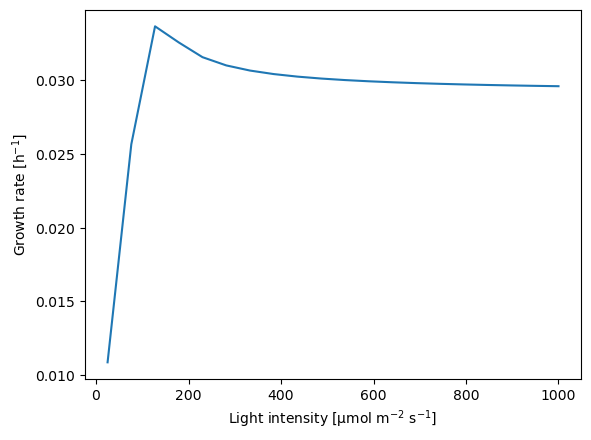

In [6]:
if False:
    # Make container to save the mus
    mus = {}

    for intens in np.linspace(25,1000, 20):
        # Simulate
        s = Simulator(m)

        s.update_parameter("pfd", lip.light_gaussianLED(633, intens))

        s.initialise(y0)
        t,y = s.simulate(1000)

        mus[intens] = s.get_fluxes_df().loc[:,"vBiomass"].iloc[-1]

    ax = (pd.Series(mus) * 3600 ).plot()
    ax.set_ylabel("Growth rate [h$^{-1}$]")
    ax.set_xlabel("Light intensity [µmol m$^{-2}$ s$^{-1}$]")

### Modify model to accept "light_" input
- light_ps1
- light_ps2
- light_pbs
- light_ocp

In [75]:
#!/usr/bin/env python

from pathlib import Path

import numpy as np
import pandas as pd
from scipy.integrate import simpson
import parameters

# CHANGE LOG
# 017 26.09.2022 | moved ocp description to module_update_phycobilisomes
#                | split variable pbs and ocp addition into different functions
#     04.11.2022 | adapted to the models new light handling
#                | removed unnecessary parameter replacement and model updates
#     14.11.2022 | Added OCP activation reaction and further effects on light_PSX_ML and fluorescence_pbs
#     12.01.2023 | Added OCP quenching maximum
#     06.03.2023 | switched parameters to import from parameters.py

# Define OCP activation as active, light involved process with passive reversal
def OCPactivation(
    OCP, light_ocp, kOCPactivation, kOCPdeactivation, lcf, OCPmax=1
):  # >> changed: added <<
    return (
        light_ocp * lcf * kOCPactivation * (OCPmax - OCP)
        - kOCPdeactivation * OCP
    )


# Add OCP effect on light absorption
def ps_normabsorption_ocp(time, PBS_PS1, PBS_PS2, OCP, complex_abs_ps1, complex_abs_ps2, complex_abs_pbs, PSItot, PSIItot, lcf):
    light_ps1 = (complex_abs_ps1 + complex_abs_pbs * PBS_PS1 * (1 - OCP)) / PSItot
    light_ps2 = (
        complex_abs_ps2 + complex_abs_pbs * PBS_PS2 * (1 - OCP)
    ) / PSIItot

    if isinstance(light_ps2, float) and isinstance(
        time, np.ndarray
    ):  # >> changed: added <<
        light_ps1 = np.repeat(light_ps1, len(time))
        light_ps2 = np.repeat(light_ps2, len(time))

    return light_ps1 * lcf, light_ps2 * lcf  # Get float values


def make_light_into_input(m, y0={}, init_param=None, verbose=True):
    if verbose:
        print("making absorption direct input")

    # Add the light parameters that were added as direct inputs
    p = {
        "complex_abs_ps1": 1,
        "complex_abs_ps2": 1,
        "complex_abs_pbs": 1,
        "light_ocp": 1,
    }

    m.add_parameters(p)

    # Remove unnecessary reactions and parameters
    m.remove_derived_parameter("complex_abs")
    m.remove_parameter("pfd")
    

    # # Add OCP activation
    m.update_reaction_from_args(  # >> changed: added <<
        rate_name="OCPactivation",
        function=OCPactivation,
        stoichiometry={"OCP": 1},
        args=["OCP", "light_ocp", "kOCPactivation", "kOCPdeactivation", "lcf", "OCPmax"],
    )

    # >> changed: replaced calculate_excite_ps and the depricated light function with an updated ps_normabsorption <<
    # Add the calculation of normalised absorption by the photosystems
    # Includes PBS association and OCP
    m.update_algebraic_module(
        module_name="ps_normabsorption",
        function=ps_normabsorption_ocp,
        args=["time", "PBS_PS1", "PBS_PS2", "OCP", "complex_abs_ps1", "complex_abs_ps2", "complex_abs_pbs", "PSItot", "PSIItot", "lcf"],
        check_consistency=False,
    )

    return m, y0


In [85]:
m_test = m.copy()
test, y0 = make_light_into_input(m_test, y0)

making absorption direct input


In [86]:
from module_update_phycobilisomes import OCP_absorbed_light

In [87]:
test_params = {f"complex_abs_{k}":v for k,v in m.parameters["complex_abs"].items()}
test_params.update({"light_ocp": OCP_absorbed_light(m.parameters["pfd"])})
test.update_parameters(test_params)

In [ ]:
100

In [108]:
# test_params = {
#     'complex_abs_ps1': 100.2837034338521,
#     'complex_abs_ps2': 100.32381972933348,
#     'complex_abs_pbs': 100.90676080130754,
#     'light_ocp': 9.10884712
# }

test_params = {
    'complex_abs_ps1': 100,
    'complex_abs_ps2': 100,
    'complex_abs_pbs': 100,
    'light_ocp': 100
}
test.update_parameters(test_params)

(<Figure size 1850x1050 with 4 Axes>,
 array([[<Axes: title={'center': 'ETC compounds'}, xlabel='time [s]', ylabel='non-ATP concentration [mmol mol(Chl)$^{-1}$]'>,
         <Axes: title={'center': 'O$_2$ and CO$_2$'}, xlabel='time [s]', ylabel='concentration [mmol mol(Chl)$^{-1}$]'>],
        [<Axes: title={'center': 'pH of lumen and cytoplasm'}, xlabel='time [s]', ylabel='pH'>,
         <Axes: title={'center': 'CBB & PR compounds'}, xlabel='time [s]', ylabel='concentration [mmol mol(Chl)$^{-1}$]'>]],
       dtype=object))

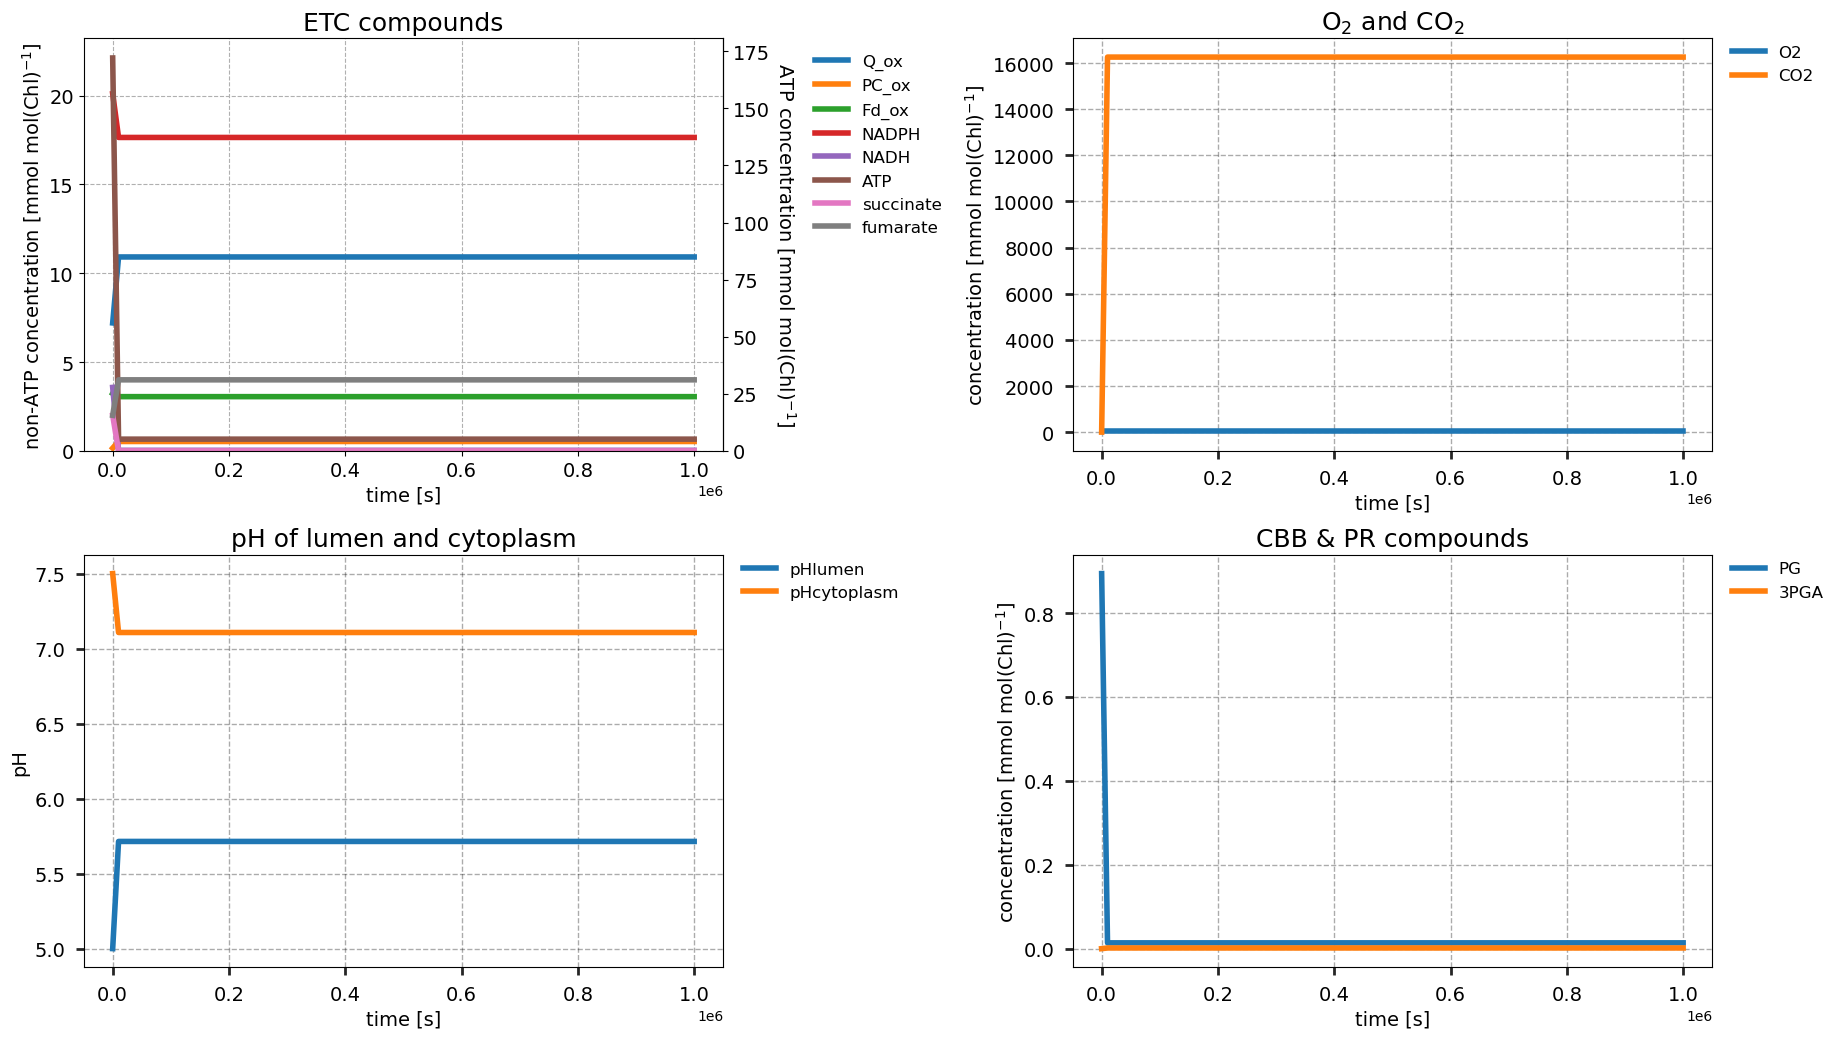

In [109]:
steps = np.linspace(0,1e6,100)

s = Simulator(test)
s.initialise(y0)
t,y = s.simulate(t_end=steps[-1], time_points=steps)
# s.plot_flux_selection(["vPS2", "vPS1"])
fnc.plot_overview_isoATP(s)

In [110]:
s.initialise(y0)
s, t, y = simulate_to_steady_state_custom(
    s,
    simulation_kwargs={
        "t_end": 1e6,
        "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
        "verbose": False,
    },
    rel_norm=True,
    return_simulator=True,
    **fnc.simulator_kwargs["loose"],
)

In [111]:
t

array([1000000.])

In [97]:
# s2 = Simulator(m)
# s2.initialise(y0)
# t,y = s2.simulate(t_end=steps[-1], time_points=steps)
# s2.plot_flux_selection(["vPS2", "vPS1"])

In [90]:
import matplotlib.pyplot as plt

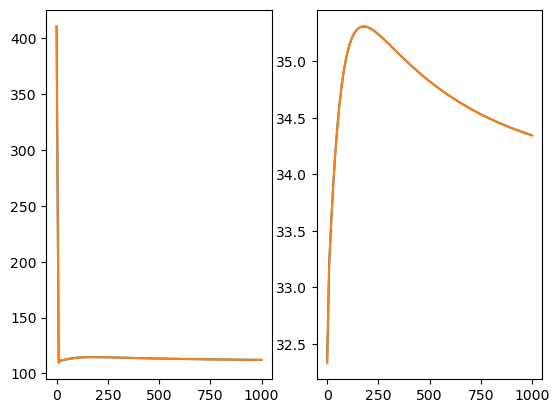

In [94]:
fig, axes = plt.subplots(1,2)
for _s in [s,s2]:
    for flux, ax in zip(["vPS1", "vPS2"], axes.flatten()):
        ax.plot(_s.get_fluxes_df().loc[:, flux])

In [9]:
m.parameters["complex_abs"]

ps1    267.788468
ps2     13.131931
pbs    597.617742
Name: absorption_m2_mgChla-1, dtype: float64

In [81]:
# Generate the input light data
_light_input = np.linspace(10, 20000, 5)

light_input = np.array(np.meshgrid(
    _light_input,
    _light_input,
    _light_input,
    _light_input,
)).T.reshape(-1,4)

light_input = pd.DataFrame(
    light_input, 
    columns = [
        "complex_abs_ps1", 
        "complex_abs_ps2", 
        "complex_abs_pbs", 
        "light_ocp"
    ]
)

light_input.shape[0]

625

In [82]:
def get_outputs(p_values, p_keys, m, y0, compounds=["ATP", "NADPH", "3PGA", "Fd_red"]):

    # Adapt and initialise the simulator
    s = Simulator(m)
    s.update_parameters(dict(zip(p_keys, p_values)))
    s.initialise(y0)

    # Simulate to steady state
    s, t, y = simulate_to_steady_state_custom(
        s,
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": False,
        },
        rel_norm=True,
        return_simulator=True,
        **fnc.simulator_kwargs["loose"],
    )

    # Get the concentrations 
    if t is not None:
        res = s.get_full_results_df()
        conc = res.loc[:, compounds].iloc[-1]
    else:
        conc = pd.Series(index=compounds)

    return conc

# Partially populate the function
_get_outputs = partial(
    get_outputs,
    p_keys=light_input.columns,
    m=m_test,
    y0=y0,
)

In [83]:
max_workers = os.cpu_count() - 2
input = light_input.to_numpy()


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    with ProcessPoolExecutor(max_workers=max_workers) as pe:
        res = list(tqdm(
            pe.map(_get_outputs, input),
            total=input.shape[0],
            disable=False
        ))

result = pd.concat(res, axis=1).T.reset_index().drop("index", axis=1)

  0%|          | 0/625 [00:00<?, ?it/s]

## Fit the regression function

In [23]:
import matplotlib.pyplot as plt

In [50]:
run_prefix = "concregression_202405282039"

result = pd.read_csv(f"../Results/{run_prefix}_results.csv", index_col=0)
input = pd.read_csv(f"../Results/{run_prefix}_params.csv", index_col=0)

In [95]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Exclude the failed simulations
failed_simulations = result.isna().any(axis=1)

# Generate some sample data
X = input[np.invert(failed_simulations)]
y = result.loc[np.invert(failed_simulations), :].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Degree of the polynomial
degree = 5

# Create polynomial features
polynomial_features = PolynomialFeatures(degree=degree)

# Create a base regressor
base_regressor = LinearRegression()

# Wrap the regressor with MultiOutputRegressor
multi_target_regressor = MultiOutputRegressor(base_regressor)

# Create a pipeline that combines the polynomial features and the linear regression model
model = make_pipeline(polynomial_features, multi_target_regressor)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.32623867727460565


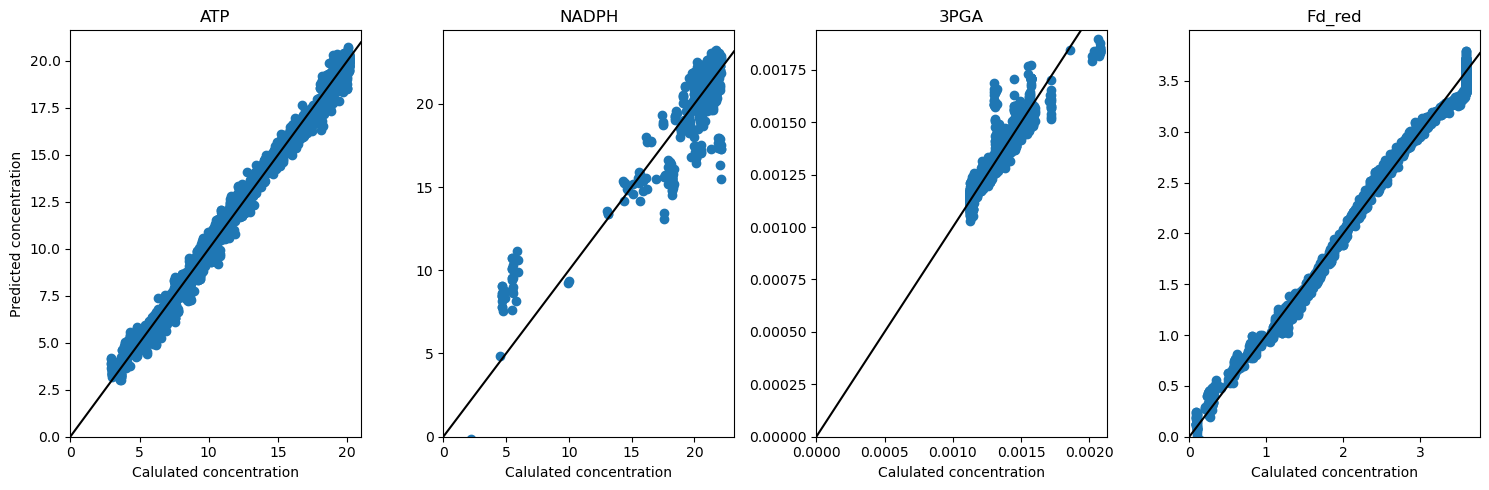

In [99]:
fig, axes = plt.subplots(1,4, figsize=(15,5))

for i, ax in enumerate(axes.flatten()):
    ax.plot(y_test[:,i], y_pred[:,i], ls="", marker="o")
    ax.set_xlabel("Calulated concentration")
    if i == 0:
        ax.set_ylabel("Predicted concentration")
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_title(result.columns[i])

    min_lim, maxlim = np.array([ax.get_ylim(), ax.get_xlim()]).min(axis=0)

    ax.plot((min_lim, maxlim), (min_lim, maxlim), c="k")

fig.tight_layout()

In [104]:
import pickle
with open("../Results/concentration_regression_model.pickle", "wb") as f:
    pickle.dump(model, f)